Kelompok 25 - LV01:
1. Alves Renato Sennellius - 2602130666
2. Howen Antonio - 2602123622

Parameter:
1. Epochs = 100
2. Batch Size = 32
3. Optimizer = Adam
4. Learning Rate = 0.00001
5. Loss Function = sparse_categorical_crossentropy
6. Total Parameters = 3,932,040
7. Trainable Parameters = 3,924,736
8. Non-trainable Parameters = 7,304 

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import math
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import keras
from tensorflow import keras
from keras import Sequential
from keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['figure.dpi'] = 300
colors = ["#B6EE56", "#D85F9C", "#EEA756", "#56EEE8"]

A search has been initiated within the folder named 'Dataset'.
There are 3200 images in the Non_Demented folder.
There are 896 images in the Mild_Demented folder.
There are 64 images in the Moderate_Demented folder.
There are 2240 images in the Very_Mild_Demented folder.
The search has been completed.


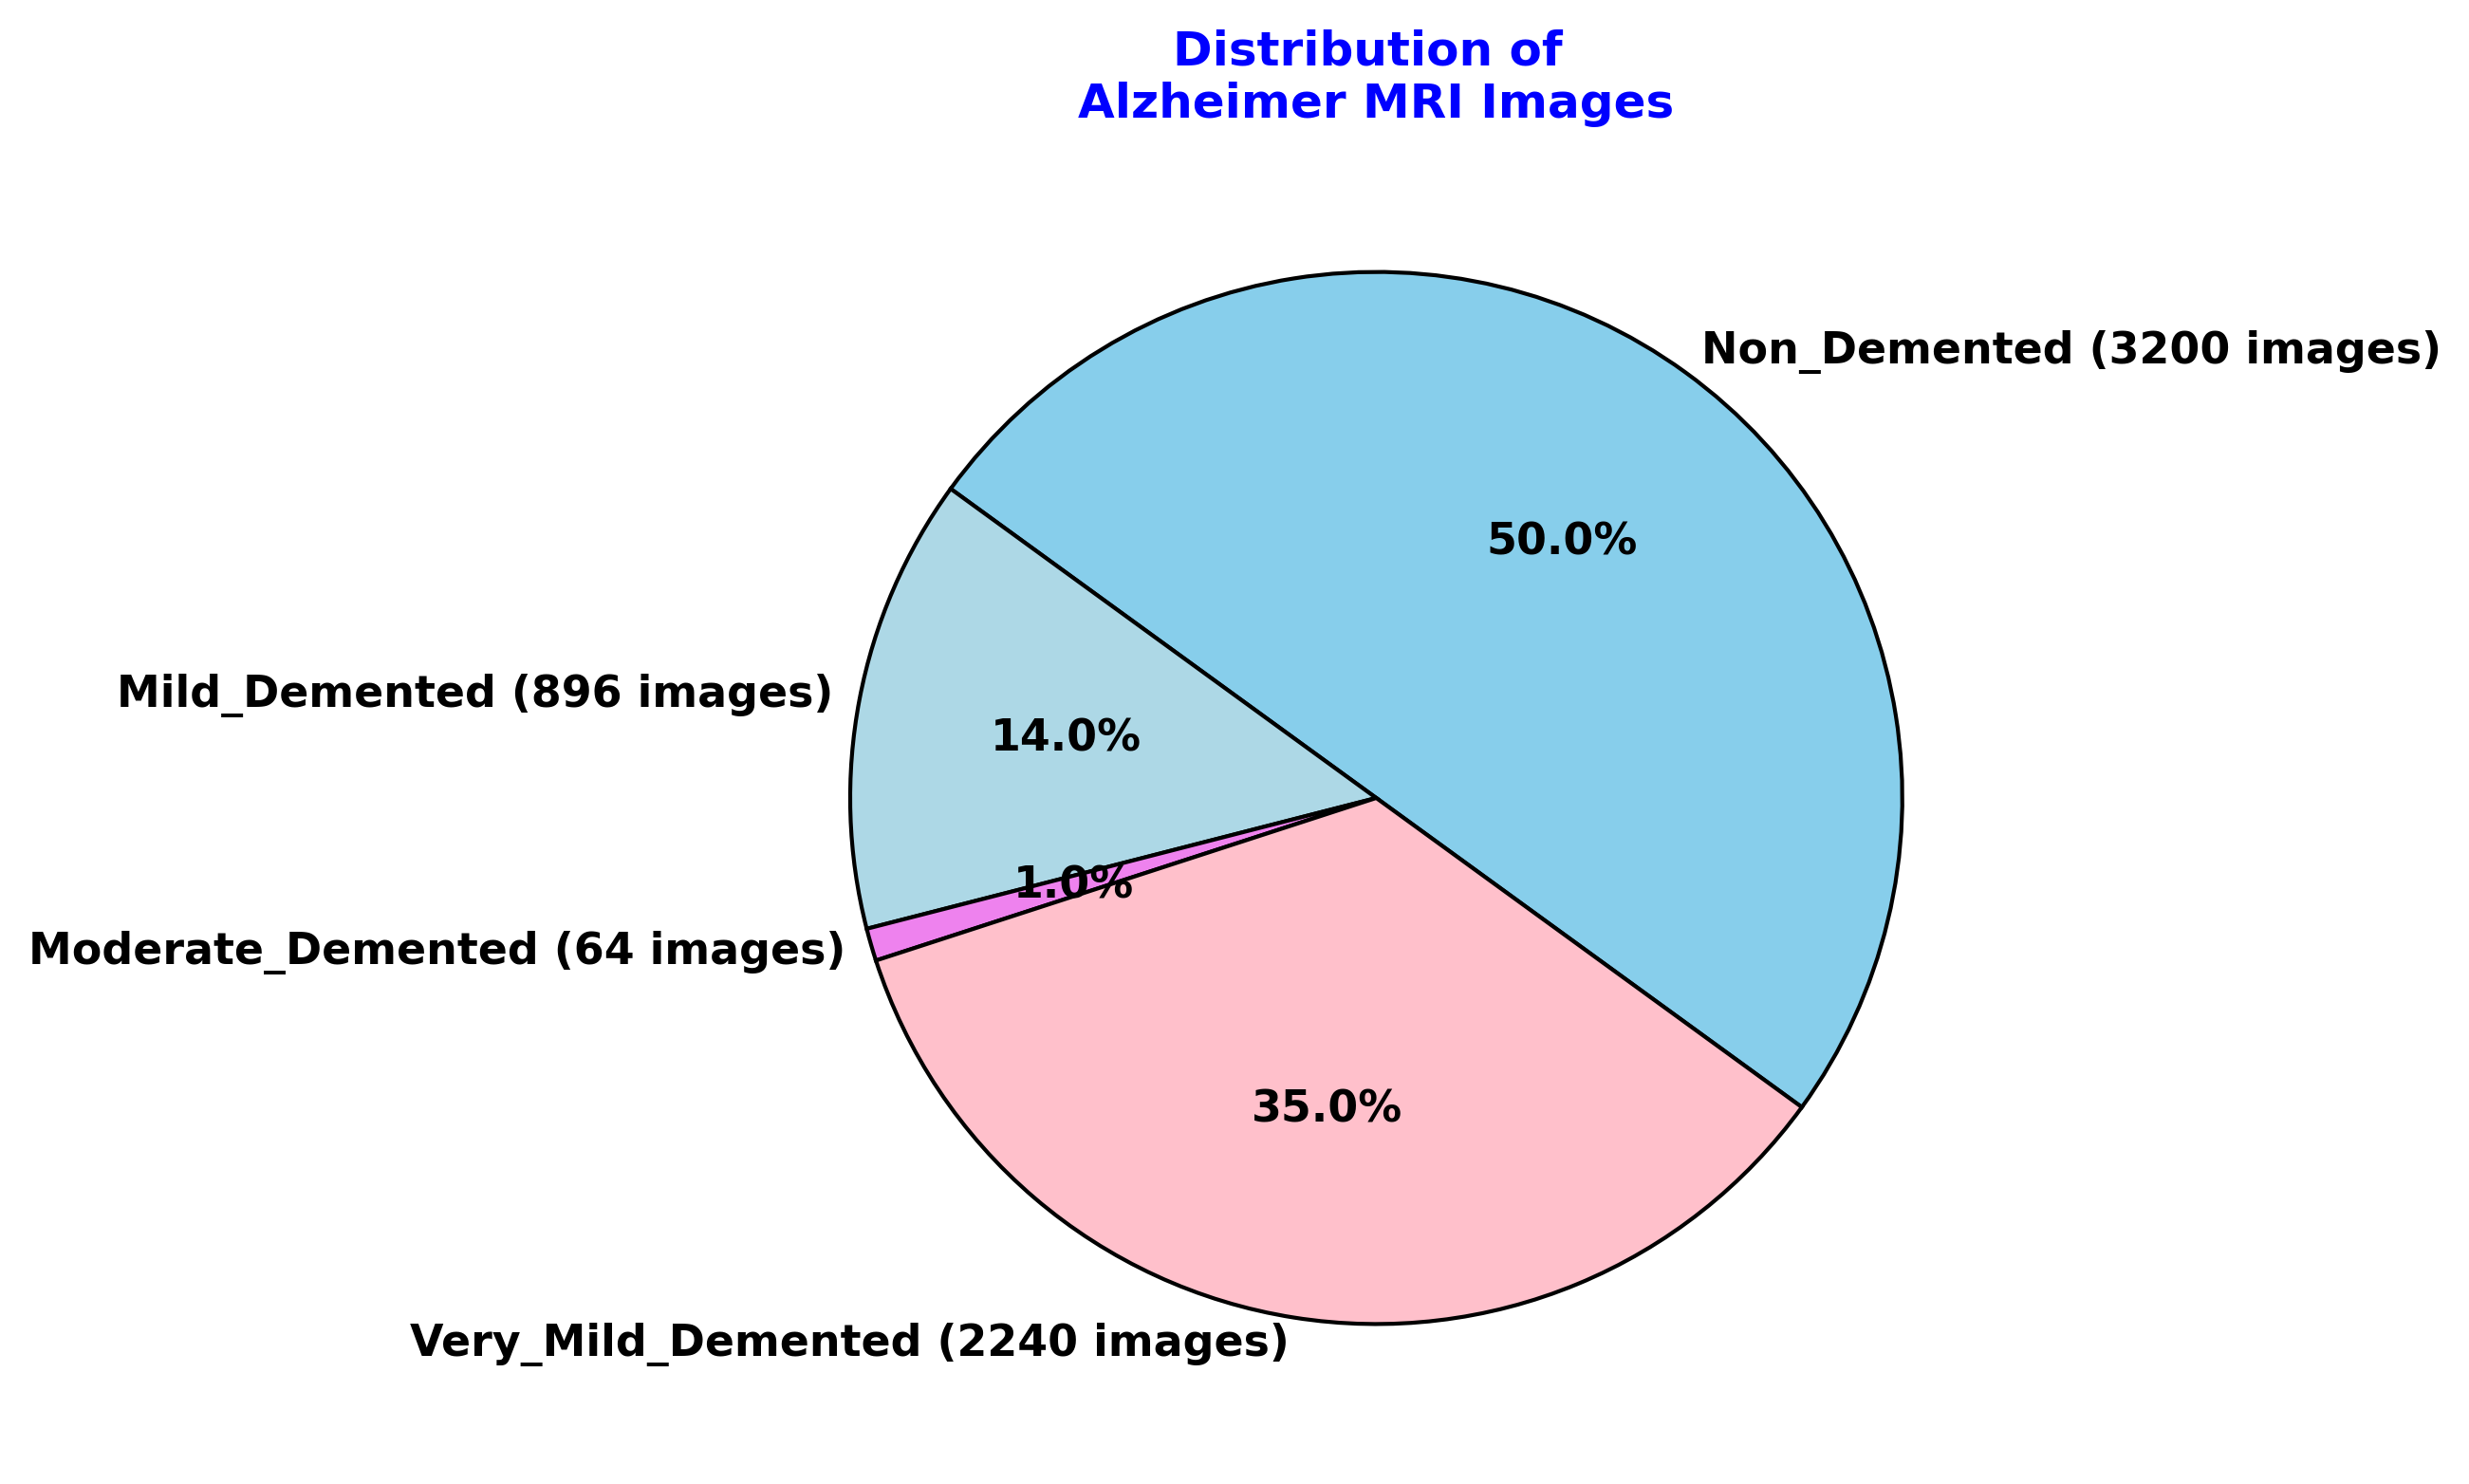

In [12]:
class_dist = {}
def image_counter(folder_path):
    basename = os.path.basename(folder_path)
    print('\033[92m'+f"A search has been initiated within the folder named '{basename}'."+'\033[0m')
    image_extensions = ['.jpg', '.jpeg', '.png']

    for root, dirs, _ in os.walk(folder_path):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            count = 0

            for filename in os.listdir(dir_path):
                file_ext = os.path.splitext(filename)[1].lower()

                if file_ext in image_extensions:
                    count += 1

            class_dist[dir_name] = count
            print(f"There are \033[35m{count}\033[0m images in the {dir_name} folder.")
    print('\033[92m'+"The search has been completed."+'\033[0m')

    keys = list(class_dist.keys())
    values = list(class_dist.values())
    explode = (0.1,)*len(keys)

    labels = [f'{key} ({value} images)' for key, value in zip(keys, values)]

    plt.pie(values, labels=labels, autopct='%1.1f%%',
            shadow=False, startangle=-36, colors=["skyblue", "lightblue", "violet", "pink"], textprops={'fontsize': 11, "fontweight" : "bold", "color":"black"},  wedgeprops=
           {'edgecolor':'black'} , labeldistance=1.05)
    plt.title("Distribution of \nAlzheimer MRI Images", size=12, fontweight="bold", color="blue")

PATH = '/kaggle/input/alzheimer-mri-dataset/Dataset'

image_counter(PATH)

In [13]:
data = tf.keras.utils.image_dataset_from_directory(PATH,
                                                batch_size = 32,
                                                image_size=(128, 128),
                                                shuffle=True,
                                                seed=42,)
class_names = data.class_names

Found 6400 files belonging to 4 classes.


Min and max pixel values in the batch -> 0.0 & 1.0


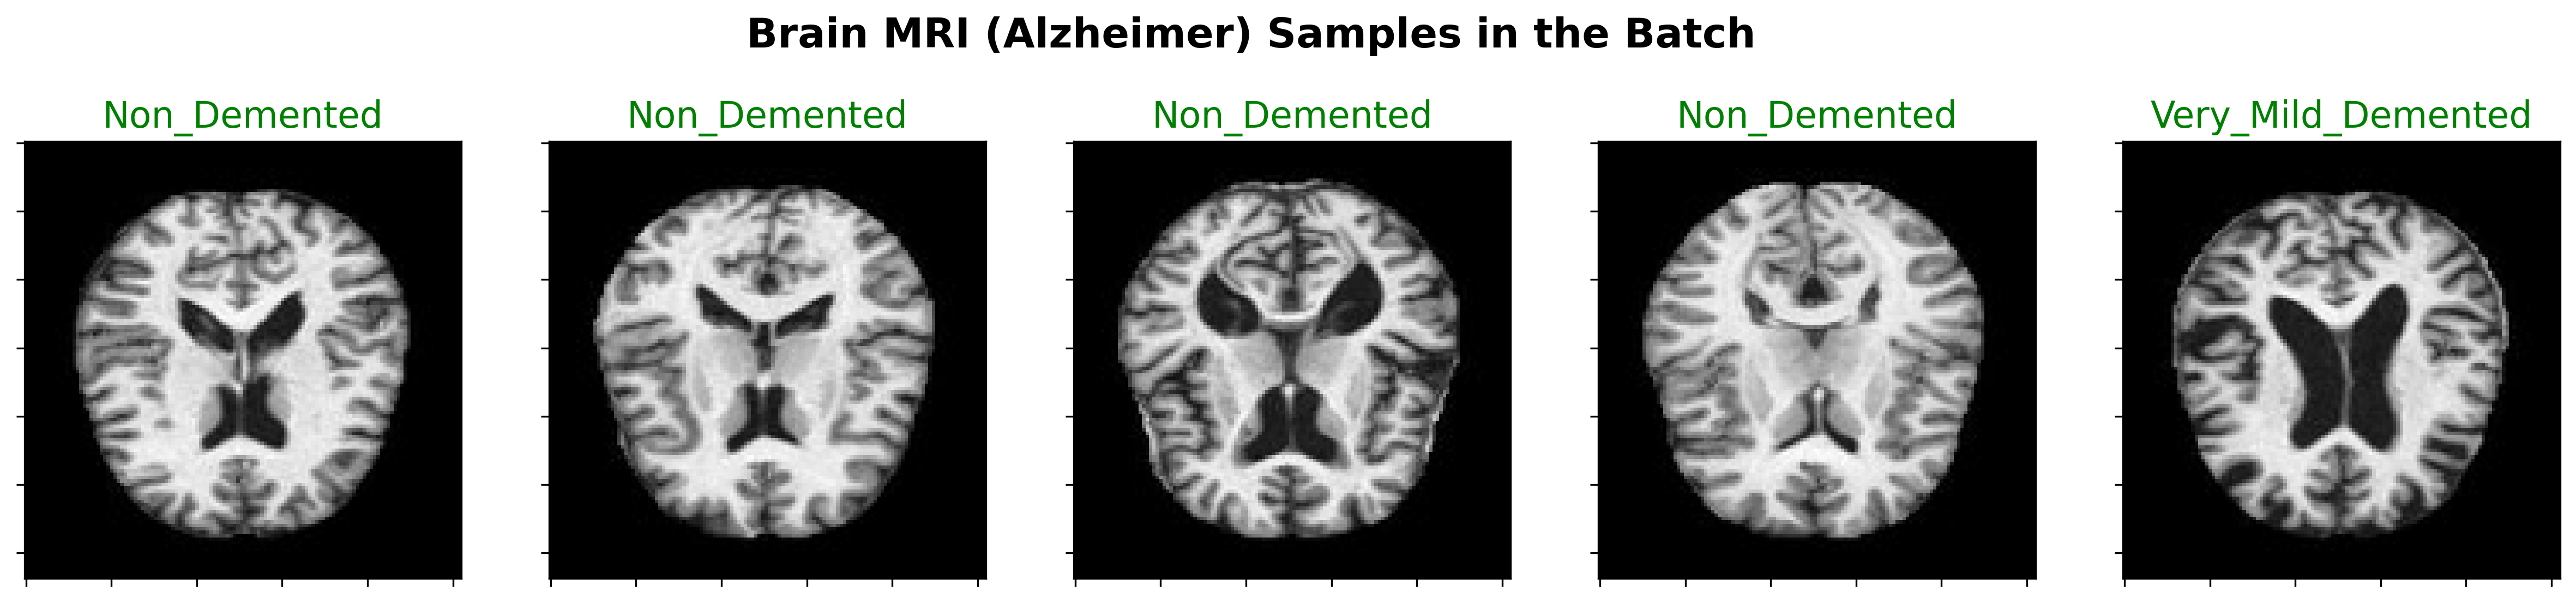

In [14]:
alz_dict = {index: img for index, img in enumerate(data.class_names)}

class Process:
    def __init__(self, data):
        self.data = data.map(lambda x, y: (x/255, y))

    def create_new_batch(self):
        self.batch = self.data.as_numpy_iterator().next()
        text = "Min and max pixel values in the batch ->"
        print(text, self.batch[0].min(), "&", self.batch[0].max())

    def show_batch_images(self, number_of_images=5):
        fig, ax = plt.subplots(ncols=number_of_images, figsize=(20,20), facecolor="white")
        fig.suptitle("Brain MRI (Alzheimer) Samples in the Batch", color="black",fontsize=18, fontweight='bold', y=0.6)
        for idx, img in enumerate(self.batch[0][:number_of_images]):
            ax[idx].imshow(img)
            class_no = self.batch[1][idx]
            ax[idx].set_title(alz_dict[class_no], color="green", fontsize=16)
            ax[idx].set_xticklabels([])
            ax[idx].set_yticklabels([])

    def train_test_val_split(self, train_size, val_size, test_size):

        train = int(len(self.data)*train_size)
        test = int(len(self.data)*test_size)
        val = int(len(self.data)*val_size)

        train_data = self.data.take(train)
        val_data = self.data.skip(train).take(val)
        test_data = self.data.skip(train+val).take(test)

        return train_data, val_data, test_data
process = Process(data)
process.create_new_batch()
process.show_batch_images(number_of_images=5)

In [15]:
train_data, val_data, test_data= process.train_test_val_split(train_size=0.8, val_size=0.1, test_size=0.1)
y_train = tf.concat(list(map(lambda x: x[1], train_data)), axis=0)
class_weight = compute_class_weight('balanced',classes=np.unique(y_train), y=y_train.numpy())
class_weights = dict(zip(np.unique(y_train), class_weight))

In [20]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation="relu", input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(2048, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1028, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation="relu"))
    model.add(Dense(4, activation="softmax"))

    optimizer = keras.optimizers.Adam(learning_rate=0.00001)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    model.summary()
    return model

model = build_model()

def checkpoint_callback():
    checkpoint_filepath = '/tmp/checkpoint/model_checkpoint.keras'

    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        save_freq='epoch',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )

    return model_checkpoint_callback

def early_stopping(patience):
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1)
    return es_callback

checkpoint_callback = checkpoint_callback()
early_stopping = early_stopping(patience=5)
callbacks = [checkpoint_callback, early_stopping]

EPOCHS = 100
history = model.fit(train_data, epochs = EPOCHS, validation_data = val_data, class_weight = class_weights)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 126, 126, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 63, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 61, 61, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 12, 12, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 576)            │         2,304 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 2048)           │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1028)           │     2,106,372 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 1028)           │         4,112 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │       526,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,932,040 (15.00 MB)

 Trainable params: 3,924,736 (14.97 MB)

 Non-trainable params: 7,304 (28.53 KB)

Epoch 1/100
 10/160 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4048 - loss: 1.7208

W0000 00:00:1711524537.874051     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.3833 - loss: 1.8575 - val_accuracy: 0.0141 - val_loss: 1.8046
Epoch 2/100


W0000 00:00:1711524543.717042     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.4010 - loss: 1.5609 - val_accuracy: 0.0141 - val_loss: 2.0162
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.4083 - loss: 1.4405 - val_accuracy: 0.0656 - val_loss: 1.9885
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.4170 - loss: 1.3172 - val_accuracy: 0.2859 - val_loss: 1.5992
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.4294 - loss: 1.2208 - val_accuracy: 0.4172 - val_loss: 1.3486
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.4296 - loss: 1.1577 - val_accuracy: 0.4156 - val_loss: 1.3683
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.4406 - loss: 1.1954 - val_accuracy: 0.4875 - val_loss: 1.1949
Epoch 8/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.4466 - loss: 1.1047 - val_accuracy: 0.4406 - val_loss: 1.2248
Epoch 9/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.4606 - loss: 1.1226 - val_accuracy

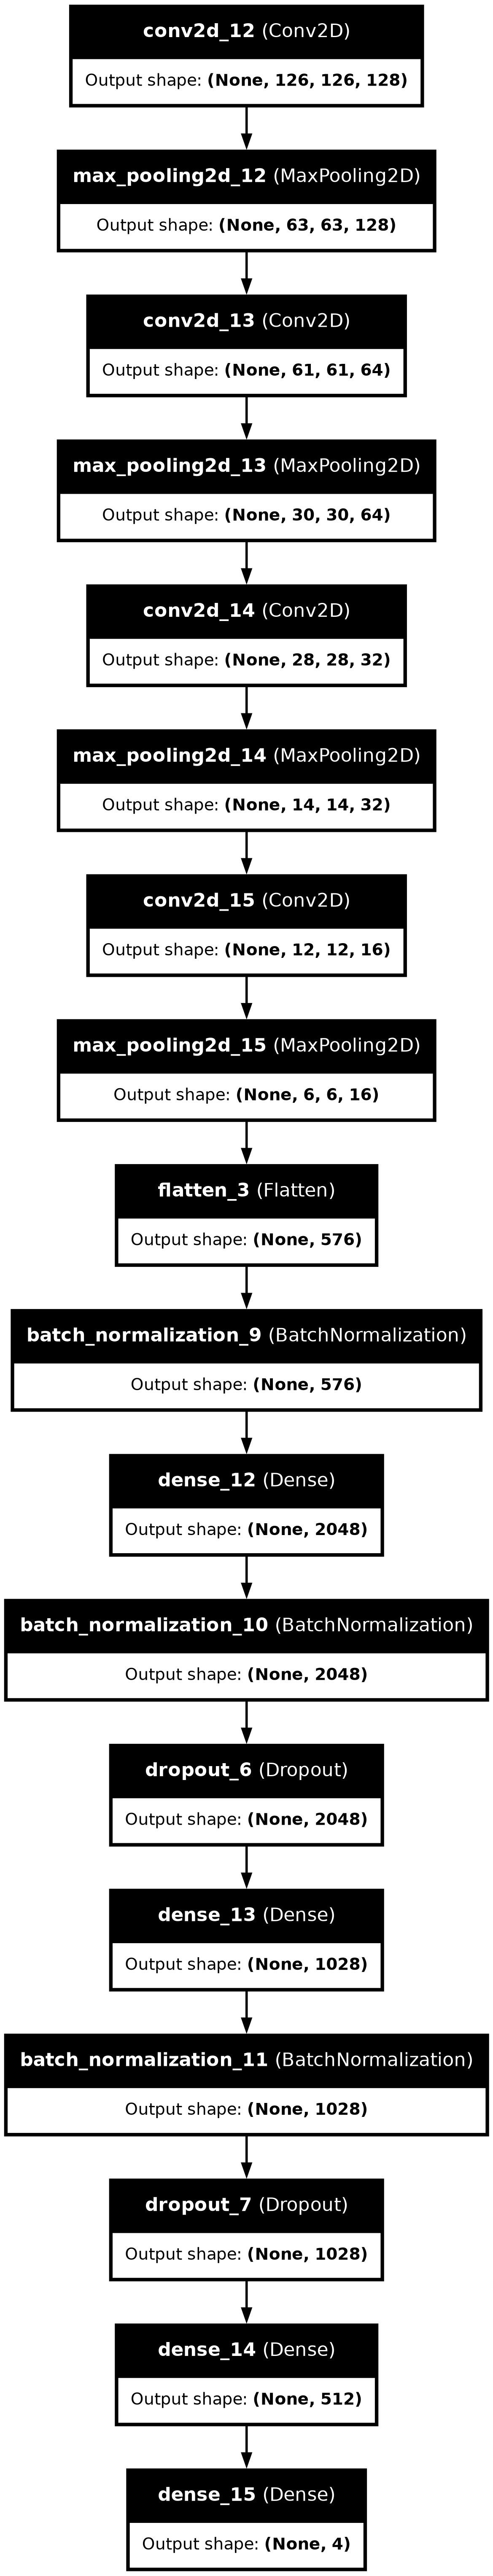

In [21]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

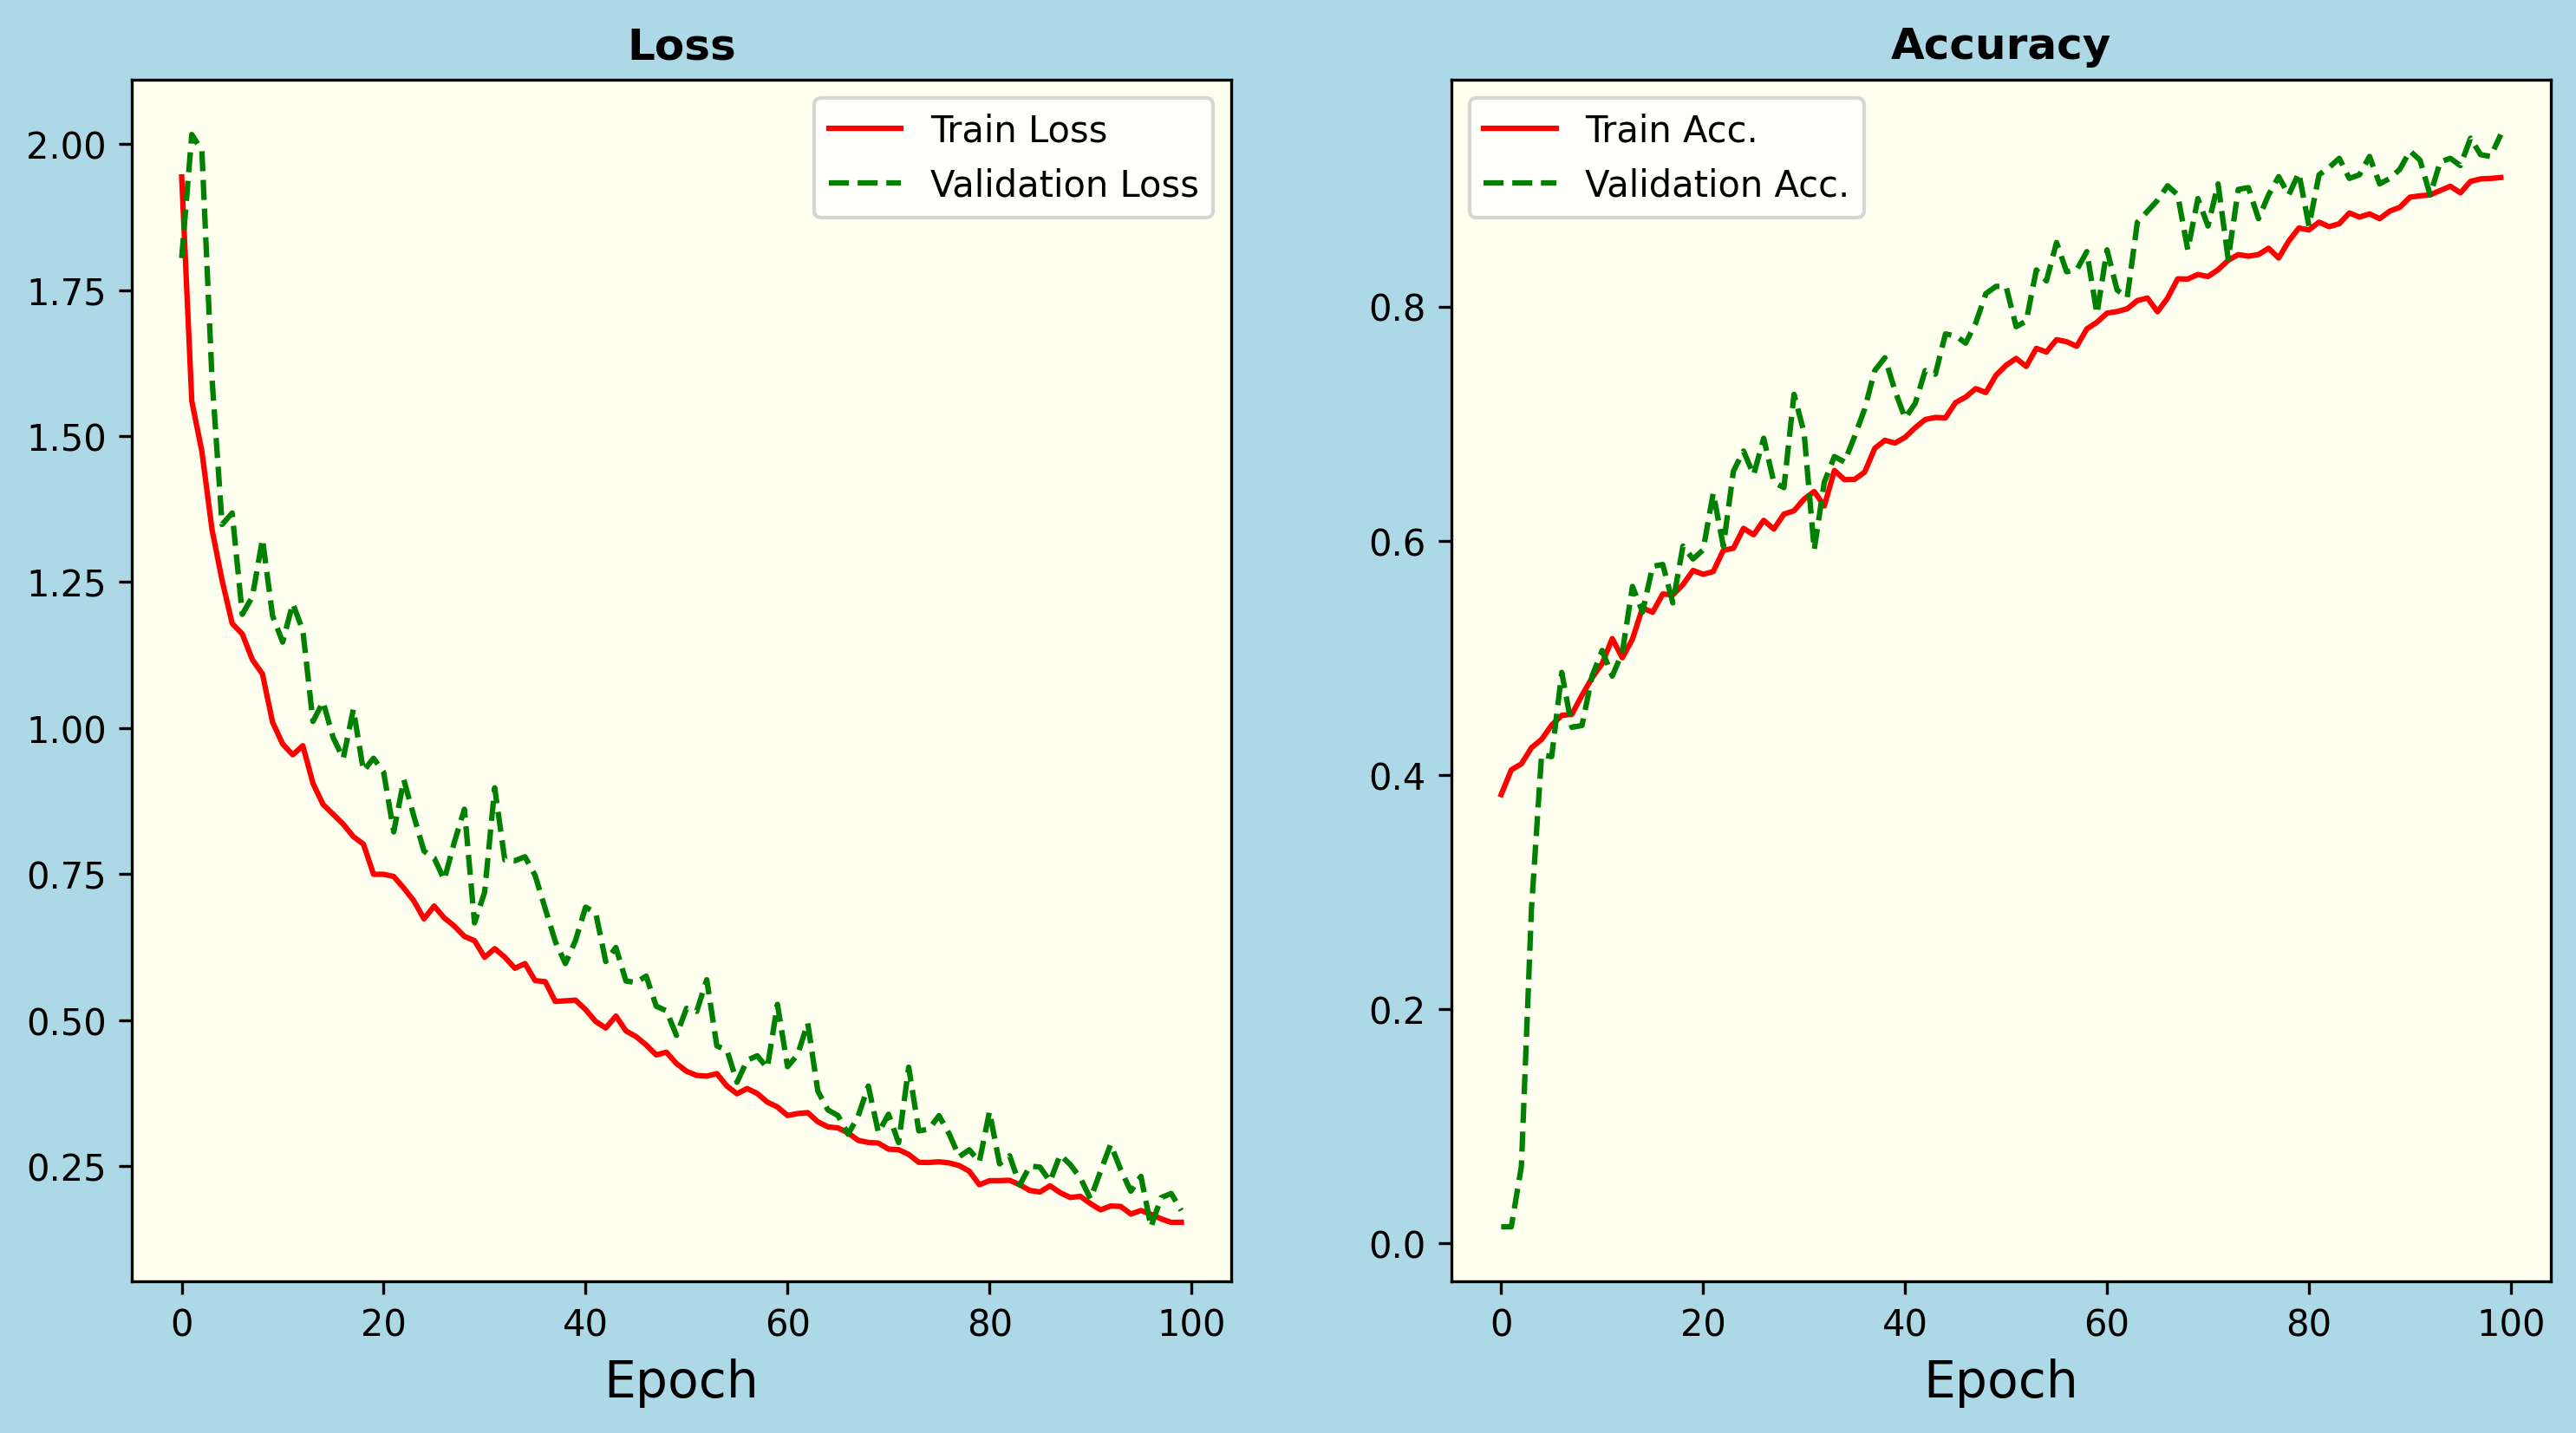

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), facecolor="lightblue")
ax[0].set_facecolor('ivory')
ax[0].set_title('Loss', fontweight="bold")
ax[0].set_xlabel("Epoch", size=14)
ax[0].plot(history.epoch, history.history["loss"], label="Train Loss", color="red")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation Loss", color="green", linestyle="dashed")
ax[0].legend()
ax[1].set_facecolor('ivory')
ax[1].set_title('Accuracy', fontweight="bold")
ax[1].set_xlabel("Epoch", size=14)
ax[1].plot(history.epoch, history.history["accuracy"], label="Train Acc.", color="red")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Acc.", color="green", linestyle="dashed")
ax[1].legend()

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9336 - loss: 0.1826


W0000 00:00:1711525127.501409     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


                    precision    recall  f1-score   support

     Mild_Demented    0.85567   1.00000   0.92222        83
 Moderate_Demented    0.77778   1.00000   0.87500         7
      Non_Demented    0.91358   0.96732   0.93968       306
Very_Mild_Demented    0.97619   0.84016   0.90308       244

          accuracy                        0.92344       640
         macro avg    0.88080   0.95187   0.91000       640
      weighted avg    0.92845   0.92344   0.92276       640



Text(286.1666666666666, 0.5, 'True')

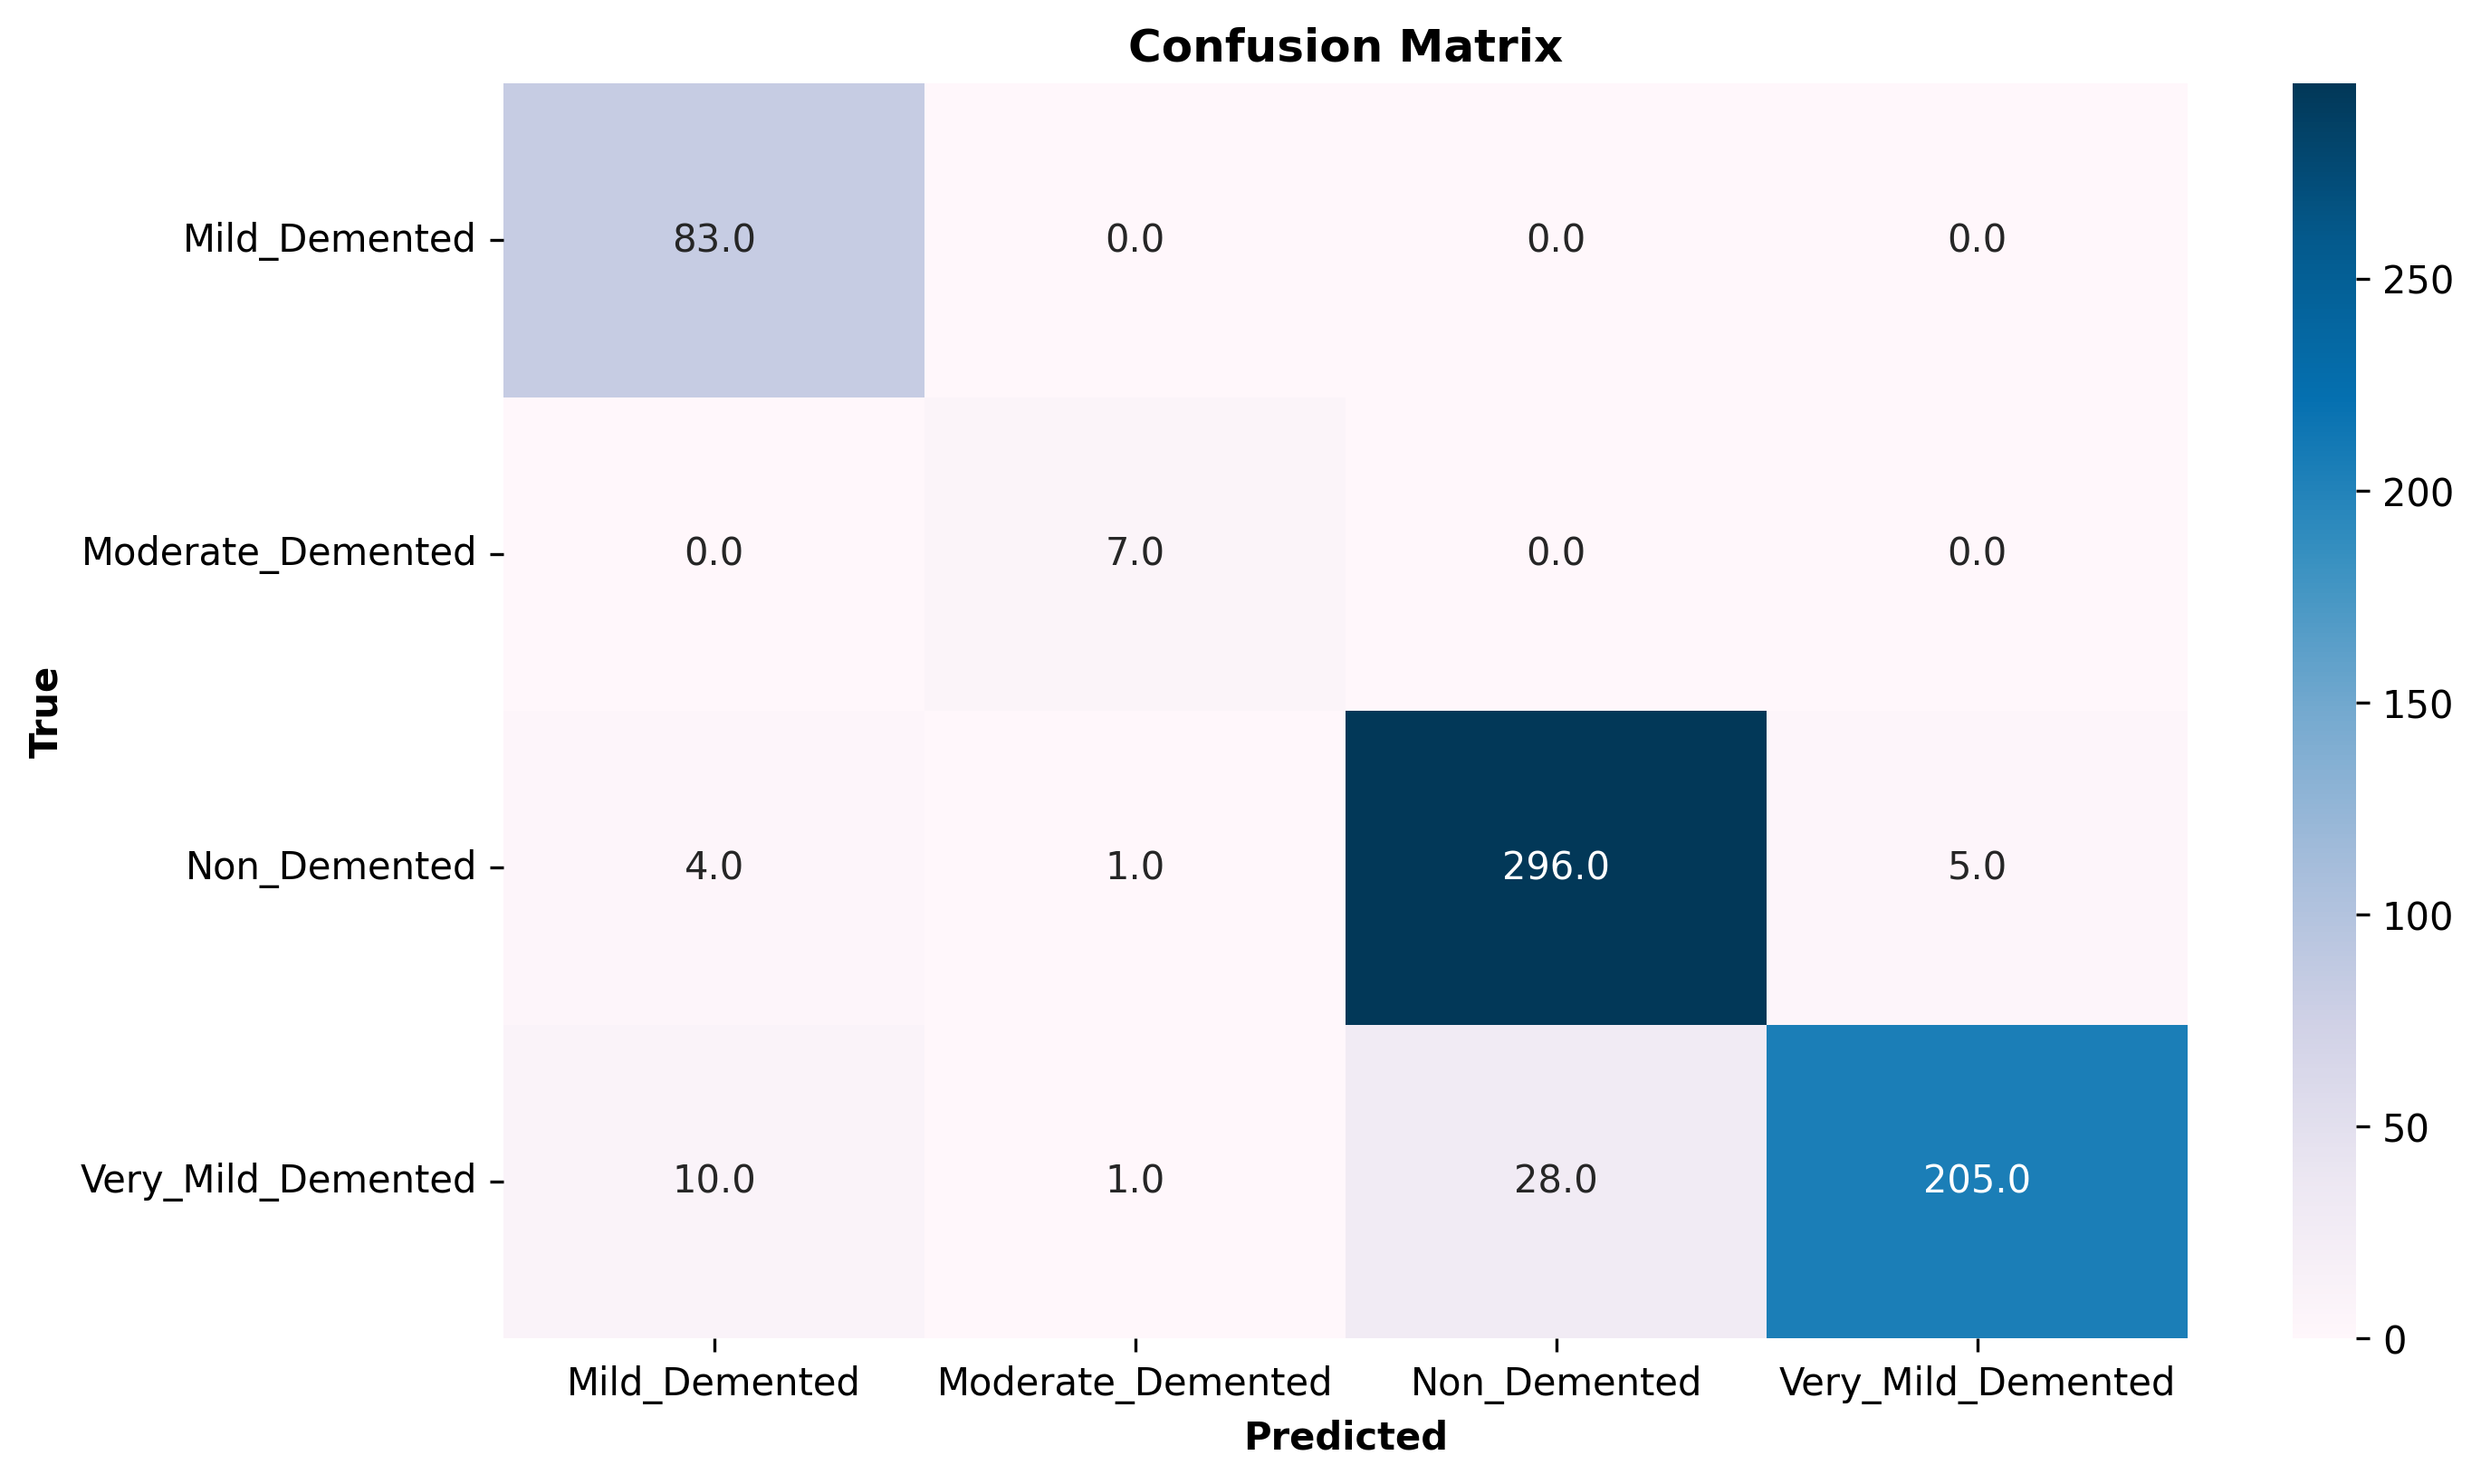

In [23]:
model.evaluate(test_data)

predictions = []
labels = []

for X, y in test_data.as_numpy_iterator():
    y_pred = model.predict(X, verbose=0)
    y_prediction = np.argmax(y_pred, axis=1)
    predictions.extend(y_prediction)
    labels.extend(y)

predictions = np.array(predictions)
labels = np.array(labels)

print(classification_report(labels, predictions, target_names=class_names, digits = 5))

cm = confusion_matrix(labels, predictions)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_df
plt.figure(figsize=(10,6), dpi=300)
sns.heatmap(cm_df, annot=True, cmap="PuBu", fmt=".1f")
plt.title("Confusion Matrix", fontweight="bold")
plt.xlabel("Predicted", fontweight="bold")
plt.ylabel("True", fontweight="bold")